In [1]:
import pandas as pd
import numpy as np
from numpy import array
from numpy import argmax
import matplotlib as mpl
import time 

import seaborn as sns
import matplotlib.pyplot as plt
import os

import pylab as pl
from scipy import stats

import matplotlib.pyplot as pyplot
from collections import Counter
from imblearn.over_sampling import SMOTE

from sklearn import svm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import log_loss

from sklearn import model_selection
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV

from sklearn import linear_model
from sklearn.linear_model import LogisticRegression

from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.cross_validation import StratifiedKFold
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier

from IPython.display import display
from IPython.display import Image
%matplotlib inline

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Final Capstone
## Exploring and modelling a tech giant's dataset.

In this notebook, we'll explore and model a dataset from China's largest third-party mobile platform, TalkingData. Understanding that everyday choices and behaviors draw a picture of who we are and what we value, we can use this information to optimize apps and manage marketing resources. The dataset contains information regarding app usage, geolocation and mobile device properties. My objective is to predict user’s demographic characteristics based on the latter information, which in return gives us valuable information that will help millions of developers and brand advertisers around the world pursue data-driven marketing efforts which are relevant to their users and catered to their preferences.


__Sections:__

[Data](#section1)<br>
[Data analysis](#section3)<br>
[Combining Data](#section4)<br>
[Training, testing and evaluation](#section5)<br>
1. [Training and testing with GridSearchCV](#section6)<br>
2. [Training and testing applying PCA](#section7)<br>
3. [Training and testing applying PCA and KMeans Clustering](#section8)<br>
4. [Running Neural Networks models](#section9)<br>

<a id='section1'></a>
## Dataset

The original dataset consisted of 7 files that contained a minum of 930 rows and a maximum of 32473067, the corresponding shapes are the following:

- App events shape: (32473067, 4)
- App labels shape: (459943, 2)
- App events shape: (3252950, 5)
- Gender age train shape: (74645, 4)
- Gender age test shape: (112071, 1)
- Label Categories shape: (930, 3)
- Phone brand device shape: (187245, 3)

Therefore, to agilize the data processing of these files I decided to use the following function to chunk the files to approximately 0,5 % of the original size:

In [2]:
def split(filehandler, delimiter=',', row_limit=4500,
          output_name_template='output_%s.csv', output_path='.', keep_headers=True):
    reader = csv.reader(filehandler, delimiter=delimiter)
    current_piece = 1
    current_out_path = os.path.join(
        output_path,
        output_name_template % current_piece
    )
    current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
    current_limit = row_limit
    if keep_headers:
        headers = next(reader)
        current_out_writer.writerow(headers)
    for i, row in enumerate(reader):
        if i + 1 > current_limit:
            current_piece += 1
            current_limit = row_limit * current_piece
            current_out_path = os.path.join(
                output_path,
                output_name_template % current_piece
            )
            current_out_writer = csv.writer(open(current_out_path, 'w'), delimiter=delimiter)
            if keep_headers:
                current_out_writer.writerow(headers)
        current_out_writer.writerow(row)

By doing this, and uploading the dataset to a Google Cloud Platform virtual machine of high performance, I was able to reduce the computational time it was taking to process my script on my personal computer.

As we have several dataset to our disposal I created various Pandas dataframes to manipulate and understand the data better. Later we will be able to combine alL the datasets to use in our quest for a rightious model.

In [3]:
# Creating Pandas dataframes for each dataset

app_events = pd.read_csv('app_events_smaller.csv')
app_labels = pd.read_csv('app_labels_smaller.csv')
events = pd.read_csv('events_smaller.csv')
gender_age_test = pd.read_csv('gender_age_test_smaller.csv')
gender_age_train = pd.read_csv('gender_age_20k.csv')
label_categories = pd.read_csv('label_categories.csv')
phone_brand_device_model = pd.read_csv('phone_brand_device_model.csv')
gender_age_train_original = pd.read_csv('gender_age_train.csv')

In [4]:
print('Training dataset header:')
display(gender_age_train.head())
print('Dataset shape:', gender_age_train.shape)
print('')
print('Events dataset header:')
display(events.head())
print('Dataset shape:', events.shape)
print('')
print('App events dataset header:')
display(app_events.head())
print('Dataset shape:', app_events.shape)
print('')
print('App labels dataset header:')
display(app_labels.head())
print('Dataset shape:', app_labels.shape)
print('')
print('Label categories dataset header:')
display(label_categories.head())
print('Dataset shape:', label_categories.shape)
print('')
print('Phone brand & device model dataset header:')
display(phone_brand_device_model.head())
print('Dataset shape:', phone_brand_device_model.shape)

Training dataset header:


,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38
3,-4938849341048082022,M,30,M29-31
4,245133531816851882,M,30,M29-31


Dataset shape: (20000, 4)

Events dataset header:


,event_id,device_id,timestamp,longitude,latitude
0,1,29182687948017175,2016-05-01 00:55:25,121.38,31.24
1,2,-6401643145415154744,2016-05-01 00:54:12,103.65,30.97
2,3,-4833982096941402721,2016-05-01 00:08:05,106.60,29.70
3,4,-6815121365017318426,2016-05-01 00:06:40,104.27,23.28
4,5,-5373797595892518570,2016-05-01 00:07:18,115.88,28.66


Dataset shape: (30000, 5)

App events dataset header:


,event_id,app_id,is_installed,is_active
0,2,5927333115845830913,1,1
1,2,-5720078949152207372,1,0
2,2,-1633887856876571208,1,0
3,2,-653184325010919369,1,1
4,2,8693964245073640147,1,1


Dataset shape: (300000, 4)

App labels dataset header:


,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


Dataset shape: (45000, 2)

Label categories dataset header:


,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


Dataset shape: (930, 3)

Phone brand & device model dataset header:


,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4
3,3669464369358936369,SUGAR,时尚手机
4,-5019277647504317457,三星,Galaxy Note 2


Dataset shape: (187245, 3)


In [5]:
app_events = app_events.drop_duplicates()

### Entity relationship diagram (ERD) & desired combined dataframe

The following image shows the composition of each csv file in relation to it's features and how we may relate them to create a final combined dataframe that can be useful for our modelling goals.

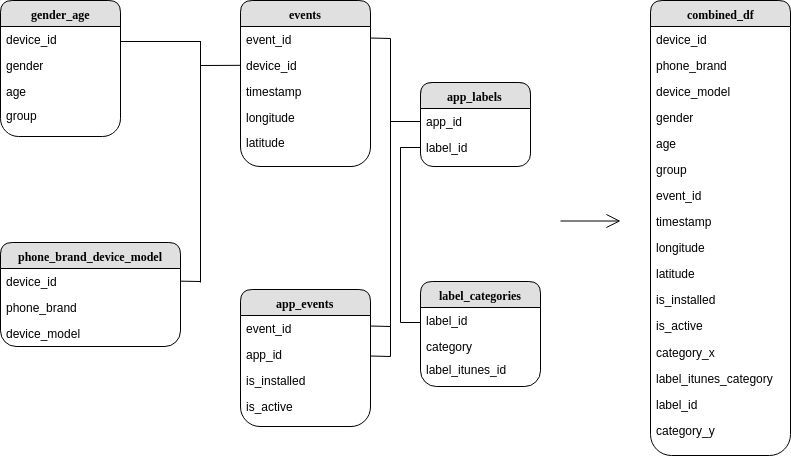

In [6]:
# This ERD was created at https://www.draw.io/
Image(filename='desired.png')

<a id='section3'></a>
## Data analysis

### Gender & Age exploration

To analyze the user gender and mobile phone comparisons, we will combine both respective datasets, gender_age_train and phone_brand_device_model, using device_id as the merging column.

#### Checking for missing values

In [7]:
gender_age_train_original.isna().sum()

device_id    0
gender       0
age          0
group        0
dtype: int64

In [8]:
phone_brand_device_model.isna().sum()

device_id       0
phone_brand     0
device_model    0
dtype: int64

#### Checking for duplicates and dropping them

In [9]:
gender_age_train_original.device_id.duplicated().sum()

0

In [10]:
phone_brand_device_model.device_id.duplicated().sum()

529

In [11]:
phone_brand_device_model.device_id.drop_duplicates().shape

(186716,)

#### Merging gender_age_train & phone_brand_device_model

In [12]:
analyze_df_1 = pd.merge(gender_age_train_original, phone_brand_device_model, left_on='device_id', right_on='device_id')

In [13]:
analyze_df_1.head()

,device_id,gender,age,group,phone_brand,device_model
0,-8076087639492063270,M,35,M32-38,小米,MI 2
1,-2897161552818060146,M,35,M32-38,小米,MI 2
2,-8260683887967679142,M,35,M32-38,小米,MI 2
3,-4938849341048082022,M,30,M29-31,小米,红米note
4,245133531816851882,M,30,M29-31,小米,MI 3


In [14]:
analyze_df_1.describe(include='all')

,device_id,gender,age,group,phone_brand,device_model
count,7.483900e+04,74839,74839.000000,74839,74839,74839
unique,NaN,2,NaN,12,120,1438
top,NaN,M,NaN,M23-26,小米,红米note
freq,NaN,48034,NaN,9629,17336,3016
mean,1.375210e+14,NaN,31.407956,NaN,NaN,NaN
std,5.327451e+18,NaN,9.867341,NaN,NaN,NaN
min,-9.223067e+18,NaN,1.000000,NaN,NaN,NaN
25%,-4.617687e+18,NaN,25.000000,NaN,NaN,NaN
50%,-1.833915e+16,NaN,29.000000,NaN,NaN,NaN
75%,4.638518e+18,NaN,36.000000,NaN,NaN,NaN


From the description above we can see that there are more male users than female users, the minimum age is 1 and maximum 96 and that the top phone brand is 小米 (Xiamoi) summing 17,336 devices in our dataset.

#### Graphical description

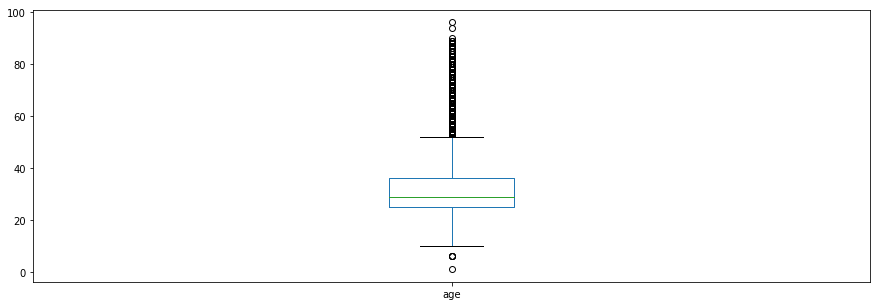

In [15]:
# Box plots
analyze_df_1.age.plot(kind='box', subplots=False, figsize=(15,5))
plt.plot()
plt.show()

From the boxplot above we can see that there are several age outliers above 55 years and some below 5 years, so will drop those outliers and plot a new boxplot:

In [16]:
analyze_df_2 = analyze_df_1[analyze_df_1.age < 55]
analyze_df_2 = analyze_df_2[analyze_df_2.age > 5]

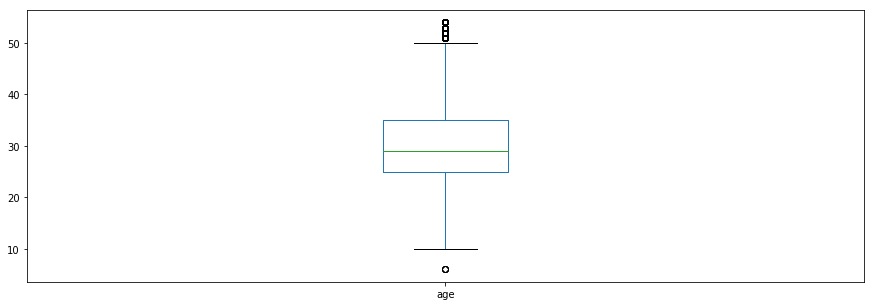

In [17]:
analyze_df_2.age.plot(kind='box', subplots=False, figsize=(15,5))
plt.plot()
plt.show()

In [18]:
analyze_df_2.age.describe()

count    72486.000000
mean        30.392917
std          8.146644
min          6.000000
25%         25.000000
50%         29.000000
75%         35.000000
max         54.000000
Name: age, dtype: float64

From the boxplot above and the corresponding description, we can see that average age of the users is 30, the minimum 6 and maximum 54. It is interesting to see that most customers are between 25 and 35 years approximately.

Text(0,0.5,'frequency')

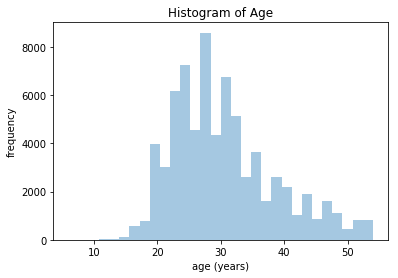

In [19]:
# Age Histogram
sns.distplot(analyze_df_2['age'], bins=30, kde=False)
plt.title('Histogram of Age')
plt.xlabel('age (years)')
plt.ylabel('frequency')

M    46806
F    25680
Name: gender, dtype: int64


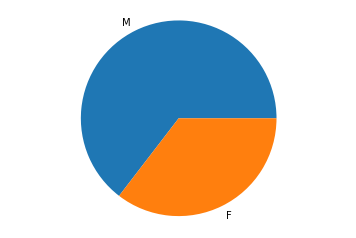

In [20]:
# Gender count
counts = analyze_df_2.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [21]:
analyze_df_2.gender.count()

72486

In [22]:
gender_m = pd.DataFrame(analyze_df_2['gender'] == 'M')
gender_f = pd.DataFrame(analyze_df_2['gender'] == 'F')

In [23]:
print('Male percentage proportion:', ((gender_m.sum()*100)/analyze_df_2.gender.count()))

Male percentage proportion: gender    64.572469
dtype: float64


In [24]:
print('Female percentage proportion:', ((gender_f.sum()*100)/analyze_df_2.gender.count()))

Female percentage proportion: gender    35.427531
dtype: float64


We can see that the proportion of men and women in the total age group consists of 35.42 % women and 64.58 % men.

### Top 20 mobile phone exploration

We will now analyze which are the top 20 mobile phone brands:

In [25]:
analyze_df_2.columns

Index(['device_id', 'gender', 'age', 'group', 'phone_brand', 'device_model'], dtype='object')

In [26]:
analyze_df_2.phone_brand.value_counts()[0:20]

小米      16801
三星      13185
华为      12573
OPPO     5682
vivo     5555
魅族       4609
酷派       3206
联想       2582
金立       1089
HTC       987
中兴        826
乐视        744
索尼        695
努比亚       470
LG        326
中国移动      267
TCL       213
朵唯        207
海信        193
锤子        186
Name: phone_brand, dtype: int64

We can see that the top 3 brands are: 小米 (Xiaomi), 三星 (Samsung Group) and Huawei (华为).

In [27]:
analyze_df_3 = analyze_df_2['phone_brand'].groupby([analyze_df_2['gender'], analyze_df_2['age']])

In [28]:
analyze_df_3.describe()

count unique   top freq
gender age                        
F      10      2      1    小米    2
       11      4      3    联想    2
       12      5      4    三星    2
       13      5      4    三星    2
       14     14      8    小米    3
       15     10      7  OPPO    3
       16     40     10    小米    9
       17    116     19  vivo   19
       18    187     20  vivo   35
       19    536     25  OPPO  102
       20    850     39    小米  155
       21   1102     35    小米  213
       22   1087     39    小米  195
       23   1105     30    小米  220
       24   1221     34    小米  283
       25   1354     38    小米  327
       26   1627     39    小米  371
       27   1624     40    小米  405
       28   1497     40    小米  391
       29   1561     39    三星  354
       30   1224     40    小米  303
       31    984     33    小米  251
       32    870     30    小米  198
       33    855     33    三星  224
       34    866     32    三星  202
       35    675     31    三星  161
       36    536     26    三星  141
       37    558     25    三星  152
       38    476     23    华为  102
       39    434     24    三星  126
...          ...    ...   ...  ...
M      25   2397     53    小米  638
       26   2928     51    小米  725
       27   2863     52    小米  721
       28   2600     53    小米  658
       29   2799     51    小米  723
       30   2518     46    小米  579
       31   2019     52    小米  464
       32   1776     50    小米  455
       33   1629     43    三星  348
       34   1725     48    小米  395
       35   1341     39    小米  318
       36   1070     41    小米  246
       37   1066     39    三星  231
       38    885     38    华为  200
       39    816     36    华为  188
       40    747     33    华为  185
       41    653     31    华为  160
       42    657     34    小米  147
       43    604     33    华为  125
       44    576     35    华为  139
       45    556     27    华为  132
       46    556     30    华为  127
       47    412     32    华为  102
       48    389     31    三星   94
       49    261     23    华为   60
       50    267     24    华为   70
       51    236     26    三星   55
       52    228     20    小米   47
       53    241     19    三星   69
       54    174     21    华为   41

[90 rows x 4 columns]

In [29]:
#小米, 三星, 华为, OPPO, vivo, 魅族, 酷派, 联想, 金立, HTC, 中兴, 乐视, 索尼, 努比亚, LG, 中国移动, TCL, 朵唯, 海信, 锤子

In [30]:
analyze_df_4 = analyze_df_2[analyze_df_2['phone_brand'].str.contains('小米|三星|华为|OPPO|vivo|魅族|酷派|联想|金立|HTC|中兴|乐视|索尼|努比亚|LG|中国移动|TCL|朵唯|海信|锤子')]

In [31]:
analyze_df_4.head()

,device_id,gender,age,group,phone_brand,device_model
0,-8076087639492063270,M,35,M32-38,小米,MI 2
1,-2897161552818060146,M,35,M32-38,小米,MI 2
2,-8260683887967679142,M,35,M32-38,小米,MI 2
3,-4938849341048082022,M,30,M29-31,小米,红米note
4,245133531816851882,M,30,M29-31,小米,MI 3


In [32]:
analyze_df_4.device_id.unique().shape

(70208,)

In [33]:
mpl.rcParams['font.sans-serif'] = ['Droid Sans Fallback']
mpl.rcParams['font.serif'] = ['Droid Sans Fallback']
sns.set_style({"font.sans-serif":['Droid Sans Fallback', 'Arial']})

/home/mache/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


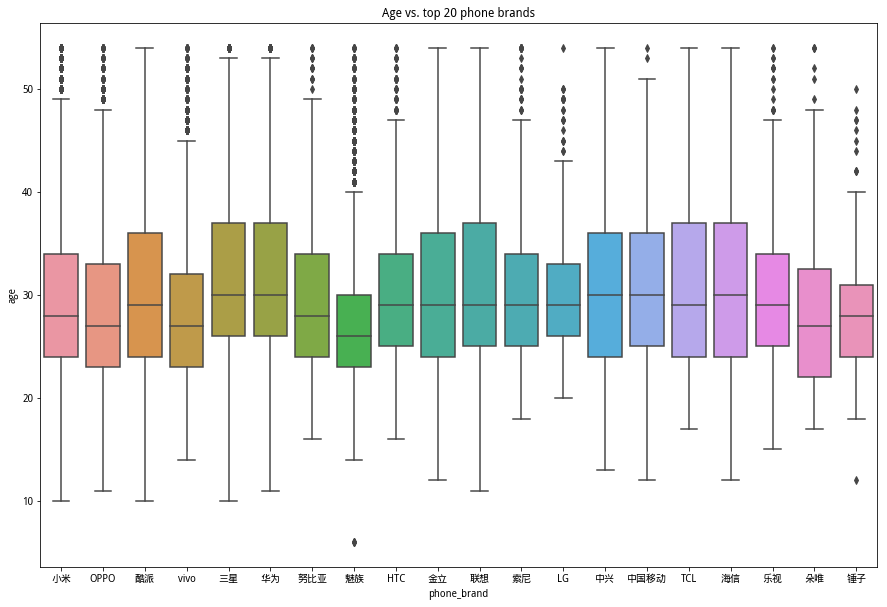

In [34]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(x="phone_brand", y="age", data=analyze_df_4, ax=ax)
plt.title('Age vs. top 20 phone brands')
plt.plot()
plt.show()

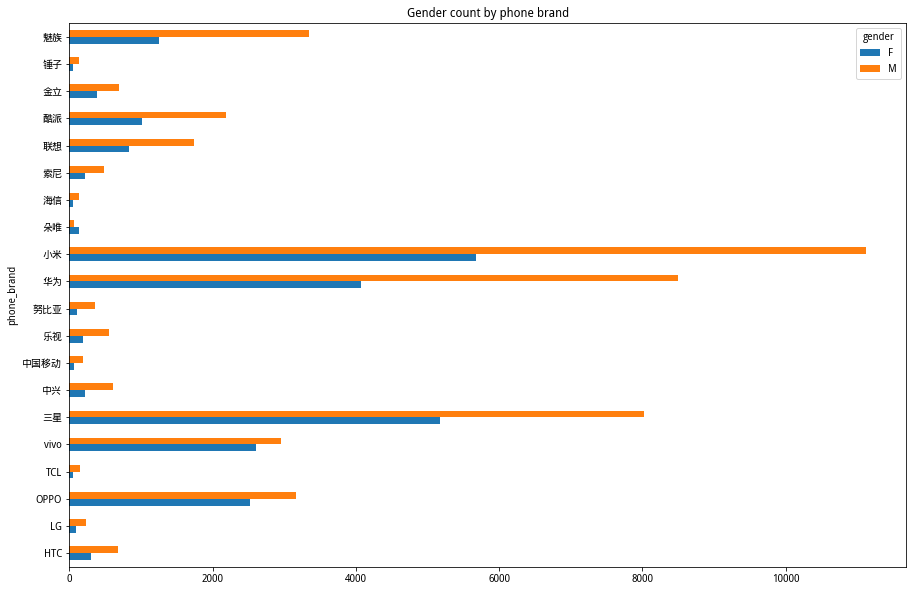

In [35]:
analyze_df_4['phone_brand'].groupby(analyze_df_4['gender']).value_counts().unstack(0).plot.barh(figsize=(15,10))
plt.title('Gender count by phone brand')
plt.plot()
plt.show()

From the bar plot above, we can see that the leading phone brand in the dataset among male and female user is 小米 (Xiaomi), in this case, almost double the number of female users is represented by men. However, in other cases such as vivo and OPPO, th proporcionality is similar.

In [36]:
df = analyze_df_4['age'].groupby(analyze_df_4['phone_brand']).mean()

In [37]:
df_mean = analyze_df_4['age'].groupby(analyze_df_4['phone_brand']).mean().reset_index()

In [38]:
df_mean

,phone_brand,age
0,HTC,30.348531
1,LG,30.812883
2,OPPO,28.755192
3,TCL,30.887324
4,vivo,28.205221
5,三星,31.802655
6,中兴,31.446731
7,中国移动,31.078652
8,乐视,30.334677
9,努比亚,29.991489


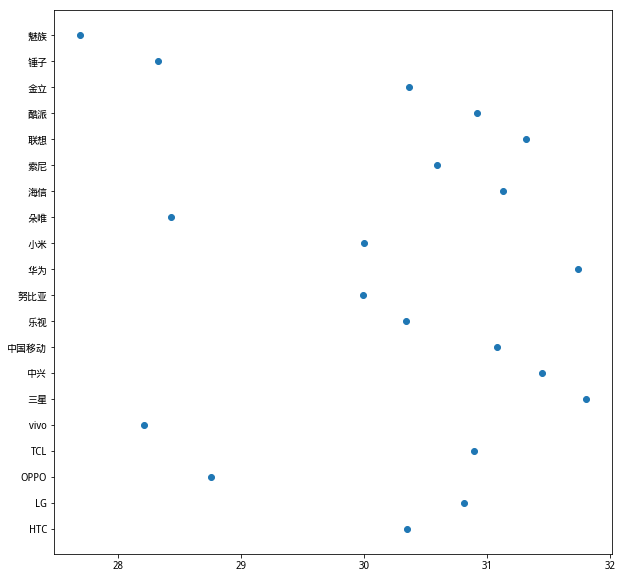

In [39]:
plt.figure(figsize=(10, 10))
plt.scatter(df_mean['age'], df_mean['phone_brand'])

As we can see from the scatter plot above and from the earlier boxplot (line 34), the average user of the top 20 mobile phone brands has an age between 30 and 32. Whilst only 5 of the top brands are used by users below 30.

<a id='section4'></a>

### Combining App/Categories Data

Combining the apps and cataegories data, will help us understan the app's categories better.

In [40]:
app_labels.head()

,app_id,label_id
0,7324884708820027918,251
1,-4494216993218550286,251
2,6058196446775239644,406
3,6058196446775239644,407
4,8694625920731541625,406


In [41]:
app_label_categories = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')

In [42]:
app_label_categories.set_index('label_id', inplace=True)

In [43]:
app_label_categories.head()

,app_id,category,label_itunes_id
label_id,,,
251,7324884708820027918,Finance,6
251,-4494216993218550286,Finance,6
251,8756705988821000489,Finance,6
251,1061207043315821111,Finance,6
251,-1491198667294647703,Finance,6


In [44]:
label_categories_mapping = pd.read_csv('label_categories_mapping.csv')
label_categories_mapping.head()

,label_itunes_id,label_itunes_category
0,1,Books
1,2,Business
2,3,Catalogs
3,4,Education
4,5,Entertainment


In [45]:
label_categories.head()

,label_id,category,label_itunes_id
0,1,NaN,26
1,2,game-game type,8
2,3,game-Game themes,8
3,4,game-Art Style,8
4,5,game-Leisure time,8


In [46]:
label_categories = pd.merge(label_categories, label_categories_mapping, left_on='label_itunes_id', right_on='label_itunes_id')

In [47]:
label_categories.head()

,label_id,category,label_itunes_id,label_itunes_category
0,1,NaN,26,Unknown
1,74,unknown,26,Unknown
2,115,unknown,26,Unknown
3,125,unknown,26,Unknown
4,126,unknown,26,Unknown


In [48]:
label_categories.set_index('label_itunes_id', inplace=True)

In [49]:
label_categories.head()

,label_id,category,label_itunes_category
label_itunes_id,,,
26,1,NaN,Unknown
26,74,unknown,Unknown
26,115,unknown,Unknown
26,125,unknown,Unknown
26,126,unknown,Unknown


In [50]:
label_categories.groupby('category').count().agg(['count', 'mean', 'min', 'max', 'sum'])

,label_id,label_itunes_category
count,833.000000,833.000000
mean,1.110444,1.110444
min,1.000000,1.000000
max,26.000000,26.000000
sum,925.000000,925.000000


In [51]:
app_labels = pd.merge(app_labels, label_categories, left_on='label_id', right_on='label_id')
app_labels.set_index('label_id', inplace=True)

In [52]:
app_labels.head()

,app_id,category,label_itunes_category
label_id,,,
251,7324884708820027918,Finance,Finance
251,-4494216993218550286,Finance,Finance
251,8756705988821000489,Finance,Finance
251,1061207043315821111,Finance,Finance
251,-1491198667294647703,Finance,Finance


In [53]:
app_cat_itunes_freq = app_labels.groupby("label_itunes_category").agg('count')

In [54]:
app_cat_itunes_freq.sort_values(by='category', ascending=False, inplace=True)

In [55]:
app_cat_itunes_freq.head()

,app_id,category
label_itunes_category,,
Unknown,37188,37188
Finance,4103,4103
Business,3409,3409
Shopping,224,224
Reference,70,70


In [56]:
app_labels_pandas = app_labels
app_labels_pandas = app_labels_pandas.sample(1000, replace=True)

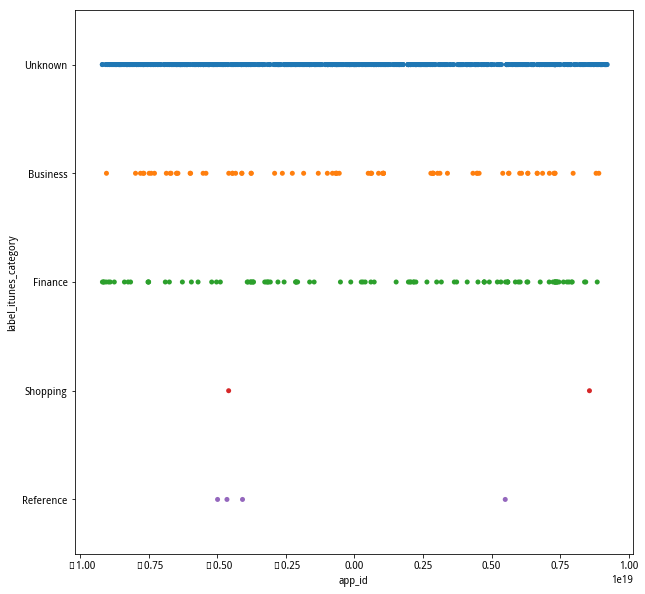

In [57]:
dimensions = (10, 10)
fig, ax = pyplot.subplots(figsize=dimensions)
sns.stripplot(x="app_id", y="label_itunes_category", data=app_labels_pandas);

We can see that a high number of apps is categorized as Unknown, and followed by a frequent use of Finance and Business apps.

### Data Transformation

We will now combine the different datasets in order to have only one dataset to train our model on.

In [58]:
combined_data_df = pd.merge(phone_brand_device_model, gender_age_train, left_on='device_id', right_on='device_id')

In [59]:
combined_data_df = pd.merge(combined_data_df, events, left_on='device_id', right_on='device_id')

In [60]:
combined_data_df = pd.merge(combined_data_df, app_events, left_on='event_id', right_on='event_id')

In [61]:
combined_data_df = pd.merge(combined_data_df, app_labels, left_on='app_id', right_on='app_id')

In [62]:
#combined_data_df = pd.merge(combined_data_df, label_categories, left_on='label_itunes_category', right_on='label_itunes_category')

In [63]:
combined_data_df.head()

,device_id,phone_brand,device_model,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,category,label_itunes_category
0,7102818890309647918,华为,荣耀6 Plus,M,34,M32-38,19508,2016-05-06 17:28:37,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
1,7102818890309647918,华为,荣耀6 Plus,M,34,M32-38,19511,2016-05-06 17:29:20,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
2,2960733785680786248,华为,X1 7.0,F,42,F33-42,10169,2016-05-02 11:35:18,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
3,2960733785680786248,华为,X1 7.0,F,42,F33-42,15883,2016-05-01 15:35:50,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
4,6991051957078230900,华为,荣耀畅玩4C,M,25,M23-26,14983,2016-05-04 14:47:45,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown


In [64]:
combined_data_df.shape

(33545, 15)

M    22793
F    10752
Name: gender, dtype: int64


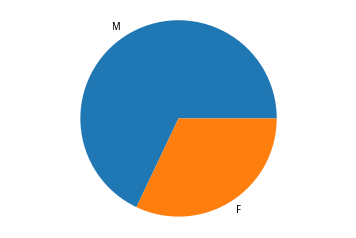

In [65]:
counts = combined_data_df.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

We will drop a fraction of male users to balance our data:

In [66]:
combined_data_df = combined_data_df.drop(combined_data_df[combined_data_df['gender'] == 'M'].sample(frac=0.6).index)

In [67]:
combined_data_df.head()

,device_id,phone_brand,device_model,gender,age,group,event_id,timestamp,longitude,latitude,app_id,is_installed,is_active,category,label_itunes_category
2,2960733785680786248,华为,X1 7.0,F,42,F33-42,10169,2016-05-02 11:35:18,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
3,2960733785680786248,华为,X1 7.0,F,42,F33-42,15883,2016-05-01 15:35:50,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
5,-941605740552358285,华为,荣耀畅玩4X,F,32,F29-32,19192,2016-05-04 17:37:53,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
6,-941605740552358285,华为,荣耀畅玩4X,F,32,F29-32,28171,2016-05-03 23:30:46,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown
7,7715946606178828084,华为,荣耀6,M,24,M23-26,29210,2016-05-02 00:23:37,0.0,0.0,6284164581582112235,1,1,Services 1,Unknown


In [68]:
combined_data_df.set_index('device_id', inplace=True)

In [69]:
combined_data_df.shape

(19869, 14)

In [70]:
combined_data_df.gender.value_counts()

F    10752
M     9117
Name: gender, dtype: int64

F    10752
M     9117
Name: gender, dtype: int64


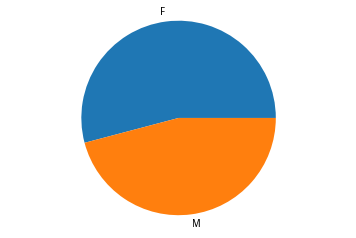

In [71]:
counts = combined_data_df.gender.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [72]:
combined_data_df.columns

Index(['phone_brand', 'device_model', 'gender', 'age', 'group', 'event_id',
       'timestamp', 'longitude', 'latitude', 'app_id', 'is_installed',
       'is_active', 'category', 'label_itunes_category'],
      dtype='object')

In [73]:
combined_data_df.drop(['device_model', 'group',
       'event_id', 'timestamp', 'longitude', 'latitude', 'app_id',
       'is_installed', 'is_active'], axis=1, inplace=True)

In [74]:
dummy = pd.get_dummies(combined_data_df)

In [75]:
dummy.head()

,age,phone_brand_HTC,phone_brand_OPPO,phone_brand_TCL,phone_brand_ZUK,phone_brand_vivo,phone_brand_一加,phone_brand_三星,phone_brand_中兴,phone_brand_中国移动,...,category_futures,category_mobile bank,category_pursue,category_service,category_unknown,label_itunes_category_Business,label_itunes_category_Finance,label_itunes_category_Reference,label_itunes_category_Shopping,label_itunes_category_Unknown
device_id,,,,,,,,,,,,,,,,,,,,,
2960733785680786248,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2960733785680786248,42,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-941605740552358285,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
-941605740552358285,32,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7715946606178828084,24,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [76]:
dummy.shape

(19869, 85)

In [77]:
features = dummy.drop(['gender_F', 'gender_M'], axis=1).columns
X = dummy[features]
Y = dummy['gender_F']
X2 = X
Y2 = Y
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [78]:
print("Normal data distribution: {}".format(Counter(Y_train)))

Normal data distribution: Counter({1: 8603, 0: 7292})


1    8603
0    7292
Name: gender_F, dtype: int64


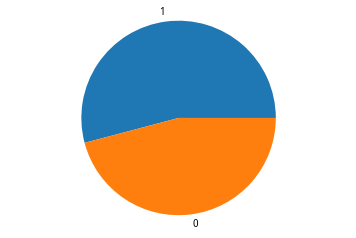

In [79]:
counts = Y_train.value_counts()
print(counts);

plt.pie(counts.values, labels=counts.keys())
plt.axis('equal')
plt.show()

In [80]:
#sm = SMOTE(random_state=12, ratio=1.0)
#X_train, Y_train = sm.fit_sample(X_train, Y_train)

In [81]:
#print("SMOTE data distribution: {}".format(Counter(Y_train)))

In [82]:
# We create several dataframes for each model

X_train_LR = X_train
X_validation_LR = X_validation
Y_train_LR = Y_train
Y_validation_LR = Y_validation

X_train_RF = X_train
X_validation_RF = X_validation
Y_train_RF = Y_train
Y_validation_RF = Y_validation

X_train_DT = X_train
X_validation_DT = X_validation
Y_train_DT = Y_train
Y_validation_DT = Y_validation

X_train_KNN = X_train
X_validation_KNN = X_validation
Y_train_KNN = Y_train
Y_validation_KNN = Y_validation

X_train_RI = X_train
X_validation_RI = X_validation
Y_train_RI = Y_train
Y_validation_RI = Y_validation

<a id='section5'></a>
### Training, testing and evaluation

<a id='section6'></a>
#### Training and testing with GridSearchCV

#### Logistic Regression (Classification L2)

In [83]:
log_reg_model = linear_model.LogisticRegression(penalty = 'l2')

In [84]:
# Define the parameter values that should be searched 
C = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [85]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = dict(C)
print(param_grid)

{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}


In [86]:
# instantiate and fit the grid
start = time.time()
grid = GridSearchCV(log_reg_model, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_LR, Y_train_LR)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 7.93


In [87]:
# View the complete results
grid.grid_scores_

/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


[mean: 0.59887, std: 0.00898, params: {'C': 0.001},
 mean: 0.61994, std: 0.00884, params: {'C': 0.01},
 mean: 0.62259, std: 0.01064, params: {'C': 0.1},
 mean: 0.62303, std: 0.01022, params: {'C': 1},
 mean: 0.62271, std: 0.01078, params: {'C': 10},
 mean: 0.62271, std: 0.01076, params: {'C': 100},
 mean: 0.62259, std: 0.01084, params: {'C': 1000}]

In [88]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.623026108839
{'C': 1}


In [89]:
log_reg_model = linear_model.LogisticRegression(penalty = 'l2', C=0.001)
log_reg_model.fit(X_train_LR, Y_train_LR)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [90]:
# Prediction
log_reg_pred = log_reg_model.predict(X_train_LR)

In [91]:
# Printing classification report
print(classification_report(Y_train_LR, log_reg_pred, target_names=['gender_F', 'gender_M']))

             precision    recall  f1-score   support

   gender_F       0.62      0.34      0.44      7292
   gender_M       0.60      0.83      0.69      8603

avg / total       0.61      0.60      0.58     15895



In [92]:
# Building confusion matrix
conf_matrix_train_logR = confusion_matrix(Y_train_LR, log_reg_pred)

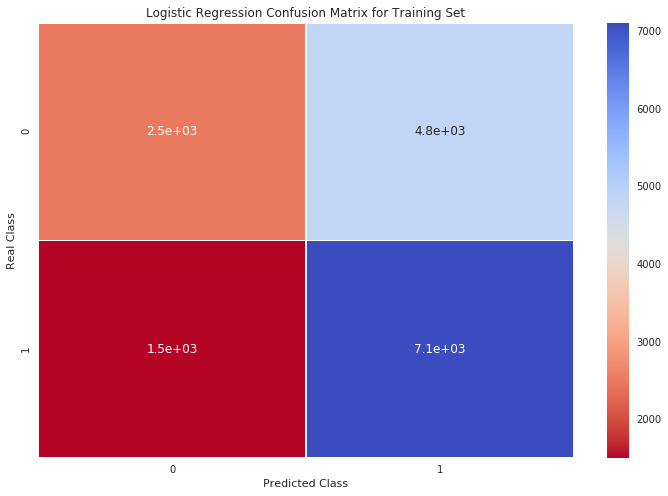

In [93]:
# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_train_logR,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Logistic Regression Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

In [94]:
scores_logR = cross_val_score(log_reg_model, X_train_LR, Y_train_LR, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_logR.mean(), scores_logR.std()*2))

Cross Validation Accuracy Scores: 0.599(+/- 0.02)


In [95]:
model_predictions = log_reg_model.predict(X_validation_LR)
score = log_reg_model.score(X_validation_LR, Y_validation_LR)
print(score)

0.625566180171


In [96]:
cm = metrics.confusion_matrix(Y_validation_LR, model_predictions)
print(cm)

[[ 670 1155]
 [ 333 1816]]


             precision    recall  f1-score   support

          0       0.67      0.37      0.47      1825
          1       0.61      0.85      0.71      2149

avg / total       0.64      0.63      0.60      3974



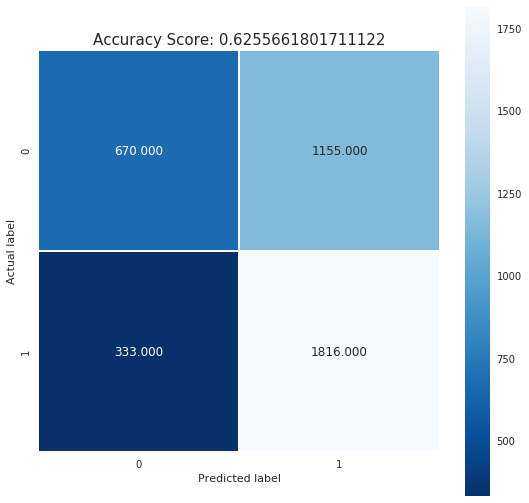

In [97]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation_LR, model_predictions))

#### Random Forest

In [98]:
rfc = ensemble.RandomForestClassifier()

In [99]:
# Define the parameter values that should be searched# Define 
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 4, num = 1)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 10, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [100]:
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(param_grid)

{'n_estimators': [1], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [101]:
# Instantiate and fit the grid
start = time.time()
grid = GridSearchCV(rfc, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_RF, Y_train_RF)
print ("Runtime %0.2f" % (time.time() - start))

Runtime 120.33


In [103]:
# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.79811261403
{'bootstrap': False, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 1}


In [104]:
rfc = ensemble.RandomForestClassifier(bootstrap=False, max_depth=None, max_features='sqrt', min_samples_leaf=1, min_samples_split=10, n_estimators=1)
rfc.fit(X_train_RF, Y_train_RF)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [105]:
# Prediction
RF_pred = rfc.predict(X_train_LR)

In [106]:
# Printing classification report
print(classification_report(Y_train_RF, RF_pred, target_names=['gender_F', 'gender_M']))

             precision    recall  f1-score   support

   gender_F       0.83      0.81      0.82      7292
   gender_M       0.84      0.86      0.85      8603

avg / total       0.84      0.84      0.84     15895



In [107]:
# Building confusion matrix
conf_matrix_train_RF = confusion_matrix(Y_train_RF, RF_pred)

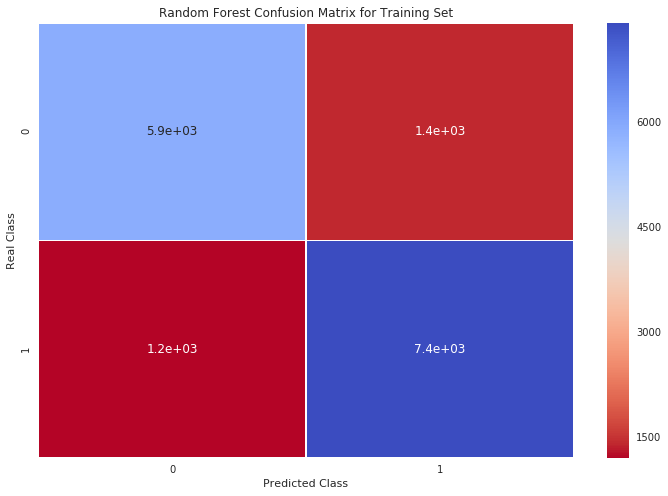

In [108]:
# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_train_RF,
           cmap='coolwarm_r',
           annot=True,
           linewidths=0.5)
plt.title('Random Forest Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

In [109]:
scores_rfc = cross_val_score(rfc, X_train_RF, Y_train_RF, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rfc.mean(), scores_rfc.std()*2))

Cross Validation Accuracy Scores: 0.784(+/- 0.02)


In [110]:
model_predictions = rfc.predict(X_validation_RF)
score = rfc.score(X_validation_RF, Y_validation_RF)
print(score)

0.788626069451


In [111]:
cm = metrics.confusion_matrix(Y_validation_RF, model_predictions)
print(cm)

[[1398  427]
 [ 413 1736]]


             precision    recall  f1-score   support

          0       0.77      0.77      0.77      1825
          1       0.80      0.81      0.81      2149

avg / total       0.79      0.79      0.79      3974



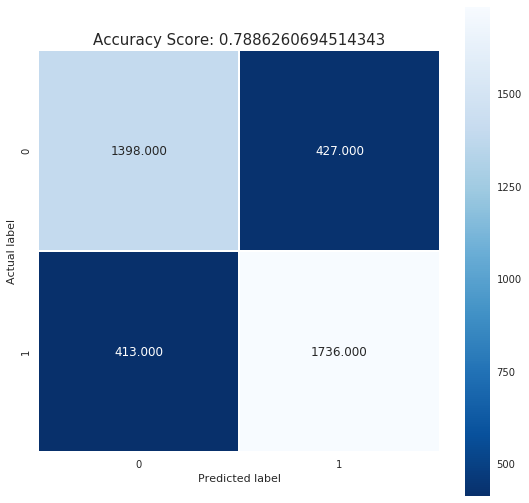

In [112]:
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation_RF, model_predictions))

#### Decision Tree

{'min_samples_split': range(10, 500, 20), 'max_depth': range(1, 20, 2), 'criterion': ['gini', 'entropy']}
Runtime 350.70
0.81981755269
{'criterion': 'gini', 'max_depth': 19, 'min_samples_split': 10}
             precision    recall  f1-score   support

   gender_F       0.87      0.59      0.70      7292
   gender_M       0.73      0.93      0.81      8603

avg / total       0.79      0.77      0.76     15895



/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


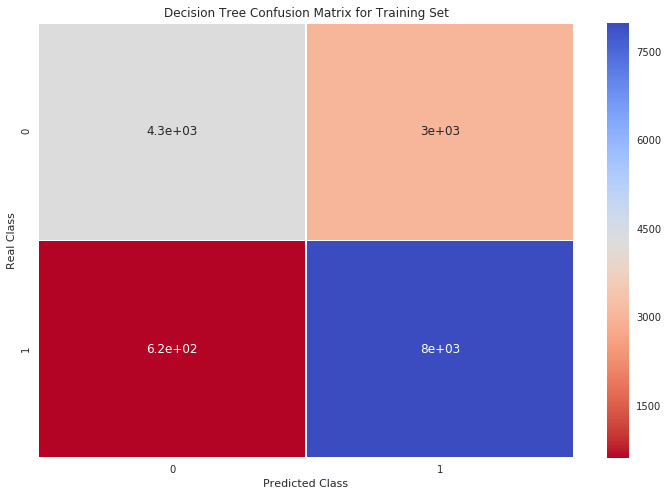

Cross Validation Accuracy Scores: 0.762(+/- 0.02)
0.76648213387
[[1066  759]
 [ 169 1980]]
             precision    recall  f1-score   support

          0       0.86      0.58      0.70      1825
          1       0.72      0.92      0.81      2149

avg / total       0.79      0.77      0.76      3974



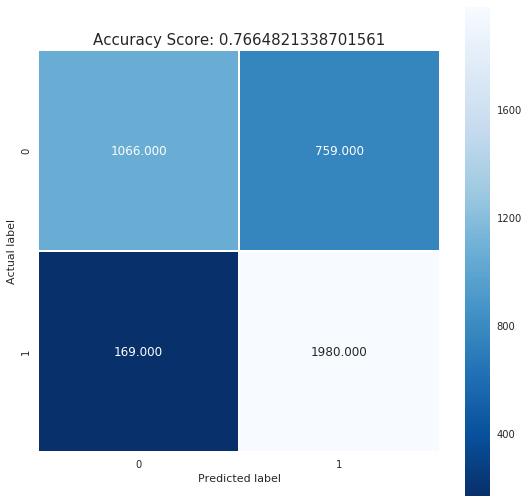

In [113]:
clf = DecisionTreeClassifier()

# Define the parameter values that should be searched
# Create a parameter grid: map the parameter names to the values that should be searched
param_grid = {'min_samples_split' : range(10,500,20),'max_depth': range(1,20,2),'criterion' : ['gini', 'entropy']}
print(param_grid)

# instantiate and fit the grid
start = time.time()
grid = GridSearchCV(clf, param_grid, cv=10, scoring='accuracy')
grid.fit(X_train_DT, Y_train_DT)
print ("Runtime %0.2f" % (time.time() - start))

# View the complete results
grid.grid_scores_

# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

clf = DecisionTreeClassifier(criterion='gini', max_depth=13, min_samples_split=10)
clf.fit(X_train_DT, Y_train_DT)

# Prediction

CLF_pred = clf.predict(X_train_LR)

# Printing classification report
print(classification_report(Y_train_DT, CLF_pred, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_train_clf = confusion_matrix(Y_train_DT, CLF_pred)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
#sns.set(rc={'axes.facecolor':'#757575ff', 'figure.facecolor':'#757575ff', 'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1.5)
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_train_clf, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Decision Tree Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_clf = cross_val_score(clf, X_train_DT, Y_train_DT, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_clf.mean(), scores_clf.std()*2))

model_predictions = clf.predict(X_validation_DT)
score = clf.score(X_validation_DT, Y_validation_DT)
print(score)

cm = metrics.confusion_matrix(Y_validation_DT, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation_DT, model_predictions))

In [114]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


#### KNN

{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9]}
Fitting 4 folds for each of 9 candidates, totalling 36 fits


[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed:  2.2min finished
/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Runtime 129.80
0.776659326832
{'n_neighbors': 7}
             precision    recall  f1-score   support

   gender_F       0.82      0.75      0.78      7292
   gender_M       0.80      0.86      0.83      8603

avg / total       0.81      0.81      0.81     15895



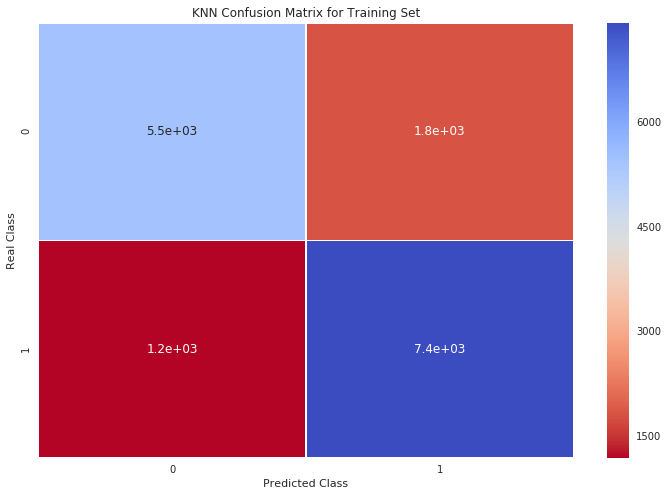

Cross Validation Accuracy Scores: 0.778(+/- 0.01)
0.76648213387
[[1314  511]
 [ 364 1785]]
             precision    recall  f1-score   support

          0       0.78      0.72      0.75      1825
          1       0.78      0.83      0.80      2149

avg / total       0.78      0.78      0.78      3974



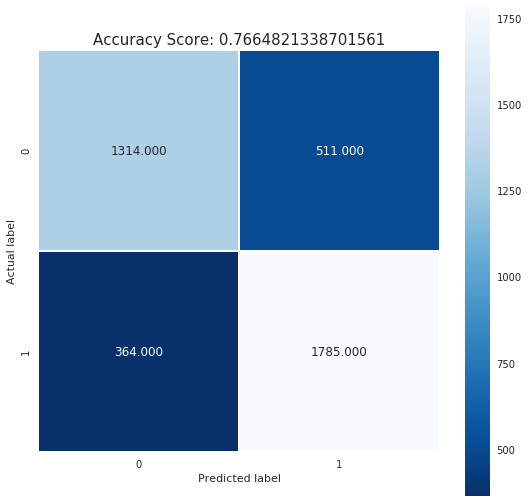

In [116]:
knn_model = KNeighborsClassifier()

# Define the parameter values that should be searched
# Create a parameter grid: map the parameter names to the values that should be searched
k_range = list(range(1, 10))
param_grid = dict(n_neighbors=k_range)
print(param_grid)

# instantiate and fit the grid
start = time.time()
grid = GridSearchCV(knn_model, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_KNN, Y_train_KNN)
print ("Runtime %0.2f" % (time.time() - start))

# View the complete results
grid.grid_scores_

# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

knn_model = KNeighborsClassifier(n_neighbors=9)
knn_model.fit(X_train_KNN, Y_train_KNN)

# Prediction

KNN_pred = knn_model.predict(X_train_KNN)

# Printing classification report
print(classification_report(Y_train_KNN, KNN_pred, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_knn = confusion_matrix(Y_train_KNN, KNN_pred)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_knn, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('KNN Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_knn = cross_val_score(knn_model, X_train_KNN, Y_train_KNN, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_knn.mean(), scores_knn.std()*2))

model_predictions = knn_model.predict(X_validation_KNN)
score = clf.score(X_validation_KNN, Y_validation_KNN)
print(score)

cm = metrics.confusion_matrix(Y_validation_KNN, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation_KNN, model_predictions))

#### Ridge

{'alpha': [25, 10, 4, 2, 1.0, 0.8, 0.5, 0.3, 0.2, 0.1, 0.05, 0.02, 0.01]}
Fitting 4 folds for each of 13 candidates, totalling 52 fits


[Parallel(n_jobs=1)]: Done  52 out of  52 | elapsed:    1.8s finished
/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


Runtime 1.82
0.623843976093
{'alpha': 10}
             precision    recall  f1-score   support

   gender_F       0.64      0.43      0.51      7292
   gender_M       0.62      0.79      0.70      8603

avg / total       0.63      0.63      0.61     15895



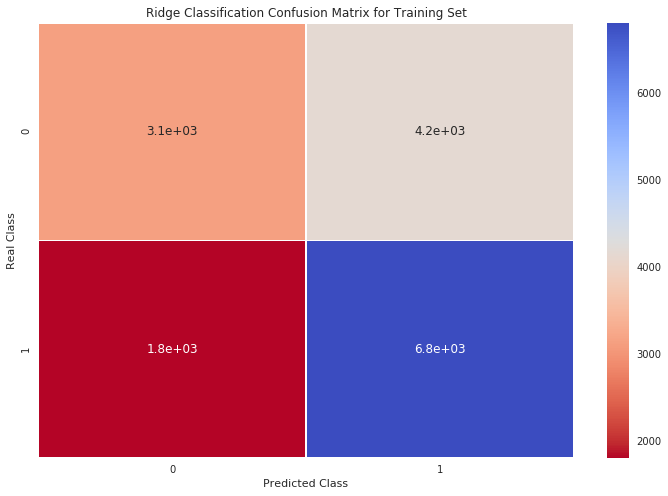

Cross Validation Accuracy Scores: 0.623(+/- 0.02)
0.632863613488
[[ 820 1005]
 [ 454 1695]]
             precision    recall  f1-score   support

          0       0.64      0.45      0.53      1825
          1       0.63      0.79      0.70      2149

avg / total       0.64      0.63      0.62      3974



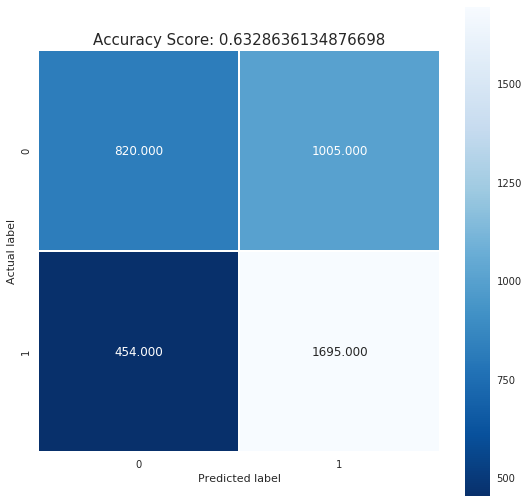

In [118]:
rclass = RidgeClassifier()

# Define the parameter values that should be searched# Define 
param_grid = {'alpha': [25,10,4,2,1.0,0.8,0.5,0.3,0.2,0.1,0.05,0.02,0.01]}
print(param_grid)

# instantiate and fit the grid
start = time.time()
grid = GridSearchCV(rclass, param_grid, verbose=1, cv=4, scoring='accuracy')
grid.fit(X_train_RI, Y_train_RI)
print ("Runtime %0.2f" % (time.time() - start))

# View the complete results
grid.grid_scores_

# Examine the best model
print(grid.best_score_)
print(grid.best_params_)

rclass = RidgeClassifier(alpha=0.8)
rclass.fit(X_train_RI, Y_train_RI)

# Prediction

rclass_pred = rclass.predict(X_train_KNN)

# Print classification report
print(classification_report(Y_train_RI, rclass_pred, target_names=['gender_F', 'gender_M']))

# Building confusion matrix
conf_matrix_rclass = confusion_matrix(Y_train_RI, rclass_pred)

# Creating heatmap of confusion matrix
plt.figure(figsize = (12,8))
sns.set(rc={'axes.grid': False, 'axes.linewidth': 1 }, font_scale=1)
sns.heatmap(conf_matrix_rclass, 
            cmap='coolwarm_r', 
            annot=True, 
            linewidths=0.5)
plt.title('Ridge Classification Confusion Matrix for Training Set')
plt.xlabel('Predicted Class')
plt.ylabel('Real Class')
plt.show()

scores_rclass = cross_val_score(rclass, X_train_RI, Y_train_RI, cv=10)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores_rclass.mean(), scores_rclass.std()*2))

model_predictions = rclass.predict(X_validation_RI)
score = rclass.score(X_validation_RI, Y_validation_RI)
print(score)

cm = metrics.confusion_matrix(Y_validation_RI, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation_RI, model_predictions))

<a id='section7'></a>
### Training and testing applying PCA

In [119]:
# Standardize the feature matrix
X = StandardScaler().fit_transform(X_train)

In [120]:
# Create a PCA that will retain 90% of the variance
pca = PCA(n_components=0.75, whiten=True)

# Conduct PCA
X_pca = pca.fit_transform(X)

In [121]:
# Show results
print('Original number of features:', X.shape[1])
print('Reduced number of features:', X_pca.shape[1])

Original number of features: 83
Reduced number of features: 53


In [122]:
def myplot(score,coeff,labels=None):
    xs = score[:,0]
    ys = score[:,1]
    n = coeff.shape[0]
    scalex = 1.0/(xs.max() - xs.min())
    scaley = 1.0/(ys.max() - ys.min())
    plt.scatter(xs * scalex,ys * scaley, c = Y_train)
    for i in range(n):
        plt.arrow(0, 0, coeff[i,0], coeff[i,1],color = 'r',alpha = 0.5)
        if labels is None:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, "Var"+str(i+1), color = 'g', ha = 'center', va = 'center')
        else:
            plt.text(coeff[i,0]* 1.15, coeff[i,1] * 1.15, labels[i], color = 'g', ha = 'center', va = 'center')

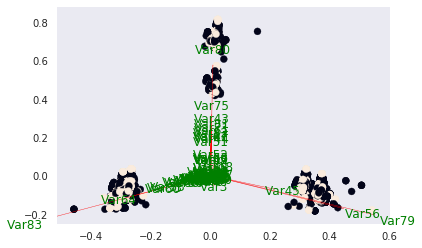

In [123]:
#Call the function. Use only the 2 PCs.
myplot(X_pca[:,0:2],np.transpose(pca.components_[0:2, :]))
plt.show()

#### Logistic Regression (L2)

In [124]:
pipe = Pipeline([('pca', pca), ('logistic', log_reg_model)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

             precision    recall  f1-score   support

   gender_F       0.58      0.10      0.18      7292
   gender_M       0.55      0.94      0.69      8603

avg / total       0.56      0.55      0.46     15895

Cross Validation Accuracy Scores: 0.544(+/- 0.01)
0.548817312531
[[ 165 1660]
 [ 133 2016]]
             precision    recall  f1-score   support

          0       0.55      0.09      0.16      1825
          1       0.55      0.94      0.69      2149

avg / total       0.55      0.55      0.45      3974



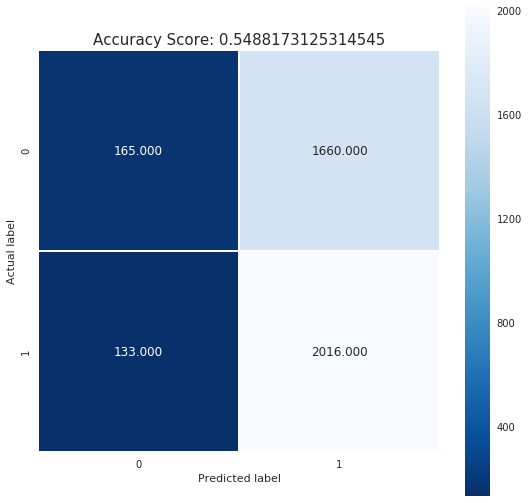

In [125]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X_validation)
score = pipe.score(X_validation, Y_validation)
print(score)

cm = metrics.confusion_matrix(Y_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation, model_predictions))

#### Random Forest Classification

In [126]:
pipe = Pipeline([('pca', pca), ('rfc', rfc)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

             precision    recall  f1-score   support

   gender_F       0.85      0.82      0.83      7292
   gender_M       0.85      0.88      0.86      8603

avg / total       0.85      0.85      0.85     15895

Cross Validation Accuracy Scores: 0.791(+/- 0.01)
0.808002013085
[[1409  416]
 [ 347 1802]]
             precision    recall  f1-score   support

          0       0.80      0.77      0.79      1825
          1       0.81      0.84      0.83      2149

avg / total       0.81      0.81      0.81      3974



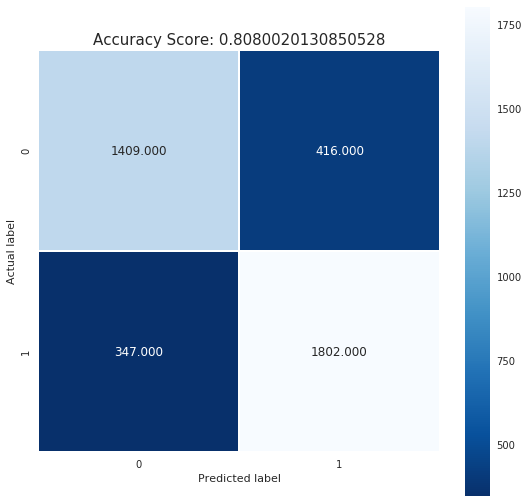

In [127]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X_validation)
score = pipe.score(X_validation, Y_validation)
print(score)

cm = metrics.confusion_matrix(Y_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation, model_predictions))

#### Decision Tree Classification

In [128]:
pipe = Pipeline([('pca', pca), ('clf', clf)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

             precision    recall  f1-score   support

   gender_F       0.75      0.74      0.75      7292
   gender_M       0.78      0.80      0.79      8603

avg / total       0.77      0.77      0.77     15895

Cross Validation Accuracy Scores: 0.743(+/- 0.01)
0.759687971817
[[1313  512]
 [ 443 1706]]
             precision    recall  f1-score   support

          0       0.75      0.72      0.73      1825
          1       0.77      0.79      0.78      2149

avg / total       0.76      0.76      0.76      3974



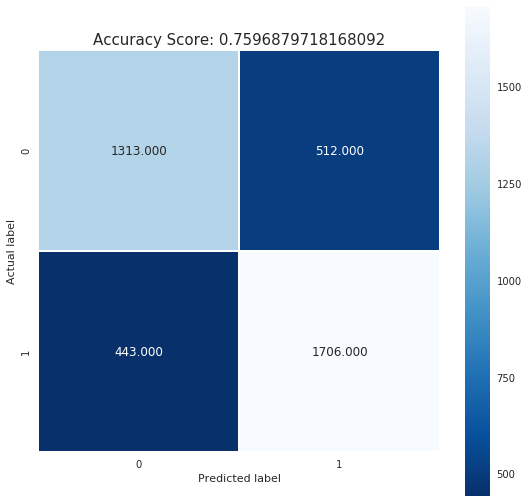

In [129]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X_validation)
score = pipe.score(X_validation, Y_validation)
print(score)

cm = metrics.confusion_matrix(Y_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation, model_predictions))

#### KNN

In [130]:
pipe = Pipeline([('pca', pca), ('knn', knn_model)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

             precision    recall  f1-score   support

   gender_F       0.82      0.75      0.78      7292
   gender_M       0.80      0.86      0.83      8603

avg / total       0.81      0.81      0.81     15895

Cross Validation Accuracy Scores: 0.769(+/- 0.02)
0.788122798188
[[1319  506]
 [ 336 1813]]
             precision    recall  f1-score   support

          0       0.80      0.72      0.76      1825
          1       0.78      0.84      0.81      2149

avg / total       0.79      0.79      0.79      3974



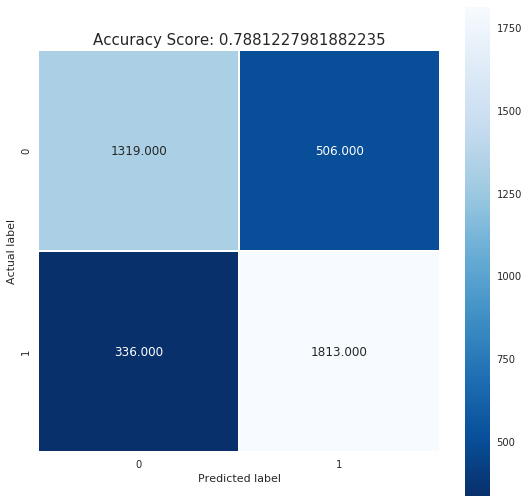

In [131]:
# Printing classification report
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X_validation)
score = pipe.score(X_validation, Y_validation)
print(score)

cm = metrics.confusion_matrix(Y_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation, model_predictions))

#### Ridge

In [132]:
pipe = Pipeline([('pca', pca), ('rclass', rclass)])
pipe.fit(X_train, Y_train)
pred = pipe.predict(X_train)

             precision    recall  f1-score   support

   gender_F       0.58      0.10      0.18      7292
   gender_M       0.55      0.94      0.69      8603

avg / total       0.56      0.55      0.46     15895

Cross Validation Accuracy Scores: 0.544(+/- 0.01)
0.548817312531
[[ 165 1660]
 [ 133 2016]]
             precision    recall  f1-score   support

          0       0.55      0.09      0.16      1825
          1       0.55      0.94      0.69      2149

avg / total       0.55      0.55      0.45      3974



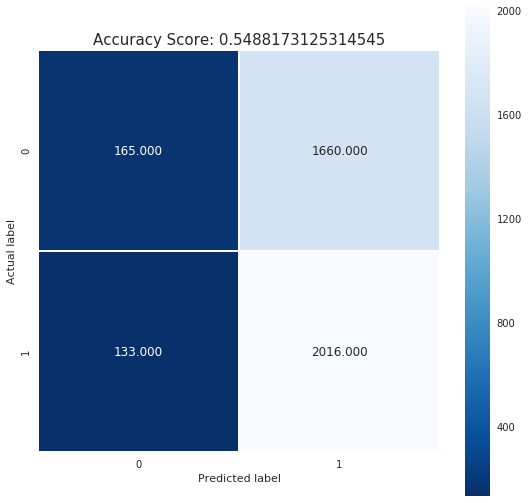

In [133]:
# Printing classification report# Printin 
print(classification_report(Y_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X_train, Y_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X_validation)
score = pipe.score(X_validation, Y_validation)
print(score)

cm = metrics.confusion_matrix(Y_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y_validation, model_predictions))

In [134]:
X_validation.shape, Y_validation.shape


((3974, 83), (3974,))

In [135]:
print("# Num of Features: ", X_train.shape[1])

# Num of Features:  83


In [136]:
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(15895, 83)
(3974, 83)
(15895,)
(3974,)


<a id='section8'></a>
### Training and testing applying PCA and KMeans Clustering

In [137]:
X2 = pd.DataFrame(X2)
print('X2 original shape:', X2.shape)
pca = PCA(n_components=50, whiten=True)

# Conduct PCA
X2_pca = pca.fit_transform(X2)
print('X2_PCA shape:', X2_pca.shape)

#Holdout
X2_train, X2_validation, Y2_train, Y2_validation = model_selection.train_test_split(X2_pca, Y2, test_size=0.2, random_state=7)

# Dataset Balancing
sm = SMOTE(random_state=12, ratio=1.0)
X2_train, Y2_train = sm.fit_sample(X2_train, Y2_train)

# KMeans model & fitting
km = KMeans(n_clusters=4)
km.fit(X2_train)

# Converting sets to Pandas dataframe
X2_train = pd.DataFrame(X2_train)
X2_validation = pd.DataFrame(X2_validation)

X2 original shape: (19869, 83)
X2_PCA shape: (19869, 50)


/home/mache/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


#### Logistic Regression (L2)

             precision    recall  f1-score   support

   gender_F       0.66      0.50      0.57      8603
   gender_M       0.60      0.74      0.66      8603

avg / total       0.63      0.62      0.61     17206

Cross Validation Accuracy Scores: 0.614(+/- 0.00)
0.629089079014
[[ 932  893]
 [ 581 1568]]
             precision    recall  f1-score   support

          0       0.62      0.51      0.56      1825
          1       0.64      0.73      0.68      2149

avg / total       0.63      0.63      0.62      3974



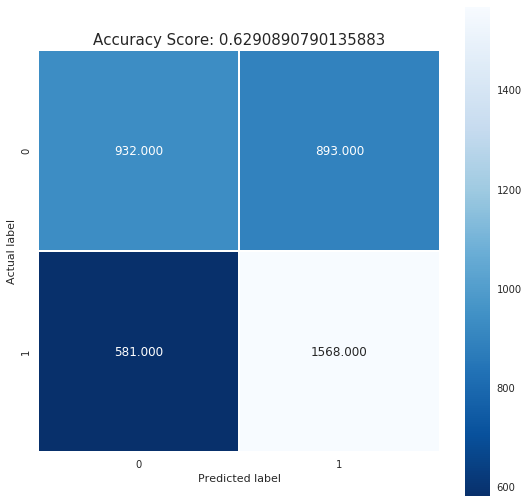

In [138]:
# Fitting Logistic Regression model
pipe = Pipeline([('logistic', log_reg_model)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X2_validation)
score = pipe.score(X2_validation, Y2_validation)
print(score)

cm = metrics.confusion_matrix(Y2_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y2_validation, model_predictions))

#### Random Forest

             precision    recall  f1-score   support

   gender_F       0.85      0.85      0.85      8603
   gender_M       0.85      0.85      0.85      8603

avg / total       0.85      0.85      0.85     17206

Cross Validation Accuracy Scores: 0.782(+/- 0.01)
0.790639154504
[[1431  394]
 [ 438 1711]]
             precision    recall  f1-score   support

          0       0.77      0.78      0.77      1825
          1       0.81      0.80      0.80      2149

avg / total       0.79      0.79      0.79      3974



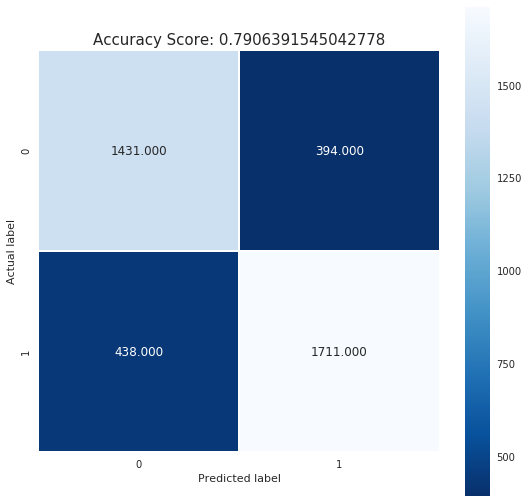

In [139]:
# Fitting Random Forest model
pipe = Pipeline([('rfc', rfc)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X2_validation)
score = pipe.score(X2_validation, Y2_validation)
print(score)

cm = metrics.confusion_matrix(Y2_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y2_validation, model_predictions))

#### Decision Tree

             precision    recall  f1-score   support

   gender_F       0.83      0.84      0.84      8603
   gender_M       0.84      0.83      0.83      8603

avg / total       0.84      0.84      0.84     17206

Cross Validation Accuracy Scores: 0.787(+/- 0.02)
0.800452944137
[[1465  360]
 [ 433 1716]]
             precision    recall  f1-score   support

          0       0.77      0.80      0.79      1825
          1       0.83      0.80      0.81      2149

avg / total       0.80      0.80      0.80      3974



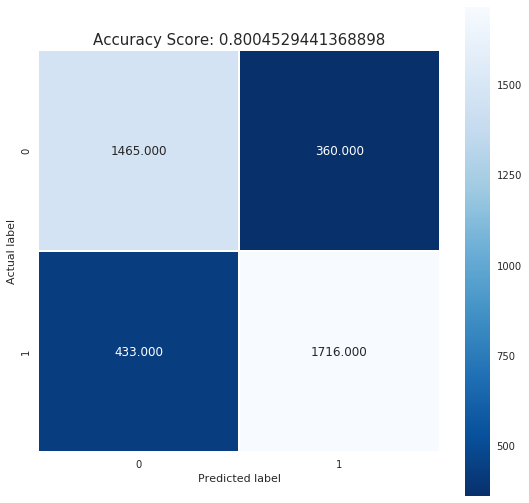

In [140]:
# Fitting Decision Tree model
pipe = Pipeline([('clf', clf)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X2_validation)
score = pipe.score(X2_validation, Y2_validation)
print(score)

cm = metrics.confusion_matrix(Y2_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y2_validation, model_predictions))

#### KNN

             precision    recall  f1-score   support

   gender_F       0.80      0.77      0.78      8603
   gender_M       0.78      0.81      0.79      8603

avg / total       0.79      0.79      0.79     17206

Cross Validation Accuracy Scores: 0.740(+/- 0.01)
0.747106190237
[[1313  512]
 [ 493 1656]]
             precision    recall  f1-score   support

          0       0.73      0.72      0.72      1825
          1       0.76      0.77      0.77      2149

avg / total       0.75      0.75      0.75      3974



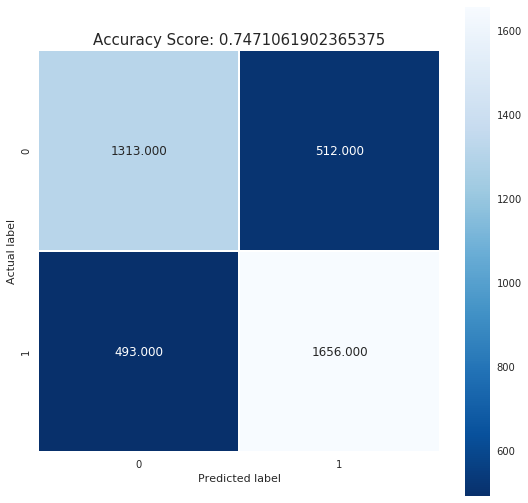

In [141]:
# Fitting KNN model
pipe = Pipeline([('knn', knn_model)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X2_validation)
score = pipe.score(X2_validation, Y2_validation)
print(score)

cm = metrics.confusion_matrix(Y2_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y2_validation, model_predictions))

#### Ridge

             precision    recall  f1-score   support

   gender_F       0.66      0.49      0.56      8603
   gender_M       0.59      0.74      0.66      8603

avg / total       0.63      0.62      0.61     17206

Cross Validation Accuracy Scores: 0.614(+/- 0.00)
0.629340714645
[[ 929  896]
 [ 577 1572]]
             precision    recall  f1-score   support

          0       0.62      0.51      0.56      1825
          1       0.64      0.73      0.68      2149

avg / total       0.63      0.63      0.62      3974



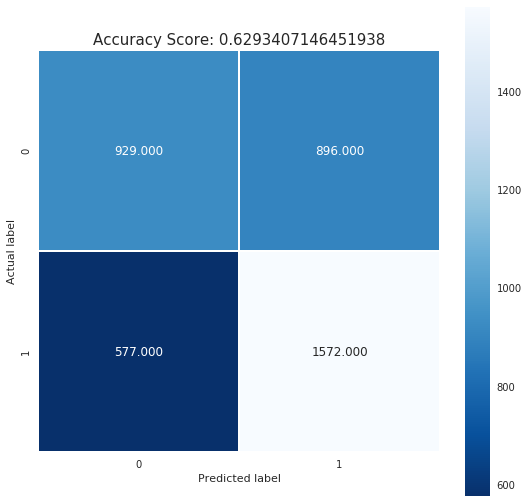

In [142]:
# Fitting Ridge model
pipe = Pipeline([('rclass', rclass)])
pipe.fit(X2_train, Y2_train)
pred = pipe.predict(X2_train)

# Printing classification report
print(classification_report(Y2_train, pred, target_names=['gender_F', 'gender_M']))

scores = cross_val_score(pipe, X2_train, Y2_train, cv=4)
print('Cross Validation Accuracy Scores: {:.3f}(+/- {:.2f})'.format(scores.mean(), scores.std()*2))

model_predictions = pipe.predict(X2_validation)
score = pipe.score(X2_validation, Y2_validation)
print(score)

cm = metrics.confusion_matrix(Y2_validation, model_predictions)
print(cm)

plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

print(classification_report(Y2_validation, model_predictions))

<a id='section9'></a>
### Running Neural Networks models

#### Creating independent datasets

In [143]:
X_train_NN = X_train
X_validation_NN = X_validation
Y_train_NN = Y_train
Y_validation_NN = Y_validation

In [144]:
X_train_NN_2 = X_train
X_validation_NN_2 = X_validation
Y_train_NN_2 = Y_train
Y_validation_NN_2 = Y_validation

#### Importing necessary libraries

In [145]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, MaxPooling2D, Activation, BatchNormalization
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop, SGD
from keras.layers.advanced_activations import PReLU
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.ensemble import VotingClassifier
from keras import optimizers

# Import the backend
from keras import backend as K

Using TensorFlow backend.


#### Defining model

In [149]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(50, input_shape = (83, ), kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))    
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, kernel_initializer='he_normal'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, kernel_initializer='he_normal'))
    model.add(Activation('softmax'))
    
    adam = optimizers.Adam(lr = 0.001)
    model.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])
    model.summary()
    
    return model

#### Creating 5 different models to ensemble

In [150]:
model1 = KerasClassifier(build_fn = mlp_model, epochs = 3)
model2 = KerasClassifier(build_fn = mlp_model, epochs = 5)
model3 = KerasClassifier(build_fn = mlp_model, epochs = 7)
model4 = KerasClassifier(build_fn = mlp_model, epochs = 8)
model5 = KerasClassifier(build_fn = mlp_model, epochs = 9)

#### Evaluating performance based on one only model

In [151]:
model_1_a = model1.fit(X_train_NN_2, Y_train_NN_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 50)                4200      
_________________________________________________________________
batch_normalization_5 (Batch (None, 50)                200       
_________________________________________________________________
activation_6 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
batch_normalization_6 (Batch (None, 50)                200       
_________________________________________________________________
activation_7 (Activation)    (None, 50)                0         
__________

In [152]:
y_pred_model_1 = model1.predict(X_validation_NN_2)

In [153]:
print('Acc: ', accuracy_score(y_pred_model_1, Y_validation_NN_2))

Acc:  0.659788626069


#### Evaluating performance based on ensambled models

In [154]:
ensemble_clf = VotingClassifier(estimators = [('model1', model1), ('model2', model2), ('model3', model3), ('model4', model4), ('model5', model5)], voting = 'soft')

In [155]:
%%time
ensemble_clf.fit(X_train_NN, Y_train_NN)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 50)                4200      
_________________________________________________________________
batch_normalization_9 (Batch (None, 50)                200       
_________________________________________________________________
activation_11 (Activation)   (None, 50)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 50)                2550      
_________________________________________________________________
batch_normalization_10 (Batc (None, 50)                200       
_________________________________________________________________
activation_12 (Activation)   (None, 50)                0         
__________

Epoch 1/7
15895/15895 [==============================] - 4s 276us/step - loss: 0.7139 - acc: 0.5422
Epoch 2/7
15895/15895 [==============================] - 3s 175us/step - loss: 0.6740 - acc: 0.5891
Epoch 3/7
15895/15895 [==============================] - 3s 176us/step - loss: 0.6570 - acc: 0.6170
Epoch 4/7
15895/15895 [==============================] - 3s 173us/step - loss: 0.6447 - acc: 0.6306
Epoch 5/7
15895/15895 [==============================] - 3s 176us/step - loss: 0.6389 - acc: 0.6387
Epoch 6/7
15895/15895 [==============================] - 3s 177us/step - loss: 0.6342 - acc: 0.6364
Epoch 7/7
15895/15895 [==============================] - 3s 173us/step - loss: 0.6274 - acc: 0.6477
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 50)                4200      
_________________________________________________________________
batch_normalization_21 (Batc (None, 

VotingClassifier(estimators=[('model1', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f64a6117b70>), ('model2', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f64a6117908>), ('model3', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f64a6117898>), ('model4', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f649b8eb940>), ('model5', <keras.wrappers.scikit_learn.KerasClassifier object at 0x7f649b8eb400>)],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [156]:
y_pred = ensemble_clf.predict(X_validation_NN)

In [157]:
print('Acc: ', accuracy_score(y_pred, Y_validation_NN))

Acc:  0.668847508807


### Conclusion

After analysing the datasets, we were able to determine that the the median age and gender group was 30 years old and male. We devided our model training and testing in four different types of modelling. First we used plain supervised models, we then applied PCA to these same models and tested their results. Later, we used K-Means clustering and evaluated their performance. And finally we modelled our dataset with neural networks and used a Keras classification MLP model to predict the user's gender. We can see the results in the following information:

Supervised models:

- Logistic Regression - Accuracy Scores - Test Set: 0.64
- Random Forest - Accuracy Scores - Test Set: 0.79
- Decision Tree - Accuracy Scores - Test Set: 0.79
- KNN - Accuracy Scores - Test Set: 0.78
- Ridge - Accuracy Scores - Test Set: 0.63

Supervised learning applying PCA:

- Logistic Regression - Accuracy Scores - Test Set: 0.55
- Random Forest - Accuracy Scores - Test Set: 0.81
- Decision Tree - Accuracy Scores - Test Set: 0.76
- KNN - Accuracy Scores - Test Set: 0.79
- Ridge - Accuracy Scores - Test Set: 0.54

Supervised learning applying PCA and KMeans Clustering:

- Logistic Regression - Accuracy Scores - Test Set: 0.63
- Random Forest - Accuracy Scores - Test Set: 0.79
- Decision Tree - Accuracy Scores - Test Set: 0.80
- KNN - Accuracy Scores - Test Set: 0.75
- Ridge - Accuracy Scores - Test Set: 0.63

Running Neural Networks models:

- Single model - Acc: 0.6597

- Ensembled models - Acc: 0.6688

As we can see, the performance with several mdoels was very satisfactory, approximately 80 %. However, I would choose the Random Forest model, it showed a great performance, low overfitting values on the training set and space to tune ever more it's hyperparameters, increasing it's accuracy. Therefore, such a model would be great to determine the demographics of certain application, and thus, being able to target, for example, advertising for that given segment.

Predicting a user's gender can help the developer in various aspects: orienting R&D investments to a specific user, spend advertising time and campaign power in a more efficent way and increase the return of investment (ROI) of the project.

In order to make it work in a production like environment, we should set up the script in a server based (cloud or phisical) environment and do some modifications in order to capture the new incoming data. This way with new incoming data we could predict new customer's gender and analyze if latter efforts, prior to our initial modelling, impact in real time to our potential or permanent customers. In addition, more computer power would be a plus to analyze the entire dataset.